### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data - Airbnb daily prices is used here
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

## Importing libraries

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

I sourced this data from http://insideairbnb.com/get-the-data/. They have Airbnb data for many cities and I will be using this data for time analysis. This is everyday price for the listings in Amsterdam and the data is from 05-December 2022 to 16-Dec 2023. I believe its the price if you book it now and might change. As this has multiple listings, I will be using mean to use this data date and price_adjusted considering, its different from the price

In [10]:
path=r'/Users/keerthiputti/Downloads'

In [13]:
df =pd.read_csv(os.path.join(path,'calendar.csv'),parse_dates=['date'],index_col=False)

In [15]:
df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2022-12-05,f,$59.00,$59.00,3,1125
1,2818,2022-12-06,t,$59.00,$59.00,3,1125
2,2818,2022-12-07,t,$59.00,$59.00,3,1125
3,2818,2022-12-08,f,$59.00,$59.00,3,1125
4,2818,2022-12-09,f,$59.00,$59.00,3,1125
...,...,...,...,...,...,...,...
2485280,522471,2023-11-30,f,$190.00,$190.00,8,25
2485281,522471,2023-12-01,f,$190.00,$190.00,8,25
2485282,522471,2023-12-02,f,$190.00,$190.00,8,25
2485283,522471,2023-12-03,f,$190.00,$190.00,8,25


In [16]:
df.columns

Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2485285 entries, 0 to 2485284
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  int64         
 6   maximum_nights  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 132.7+ MB


In [18]:
df['date'].min()

Timestamp('2022-12-05 00:00:00')

In [55]:
# Check for duplicates in the main data

dups = df.duplicated()
dups.sum()


0

In [19]:
df['date'].max()

Timestamp('2023-12-16 00:00:00')

## creating new data frame with required data

In [35]:
df_date=df[['date','adjusted_price']]

In [36]:
df_date

,date,adjusted_price
0,2022-12-05,$59.00
1,2022-12-06,$59.00
2,2022-12-07,$59.00
3,2022-12-08,$59.00
4,2022-12-09,$59.00
...,...,...
2485280,2023-11-30,$190.00
2485281,2023-12-01,$190.00
2485282,2023-12-02,$190.00
2485283,2023-12-03,$190.00


Adjusted_price has the $ sign and to make it float, we need to remove it first

In [37]:
#replacing $ with empty space 
df_date['adjusted_price'] = df_date['adjusted_price'].str.replace('$', '')
df_date['adjusted_price'] = df_date['adjusted_price'].str.replace(',', '')

In [38]:
#Changing datatype

df_date['adjusted_price']=df_date['adjusted_price'].astype('float64')

In [39]:
df_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2485285 entries, 0 to 2485284
Data columns (total 2 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   adjusted_price  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.9 MB


In [42]:
# Setting date column as index

# Set the "Date" column as the index

from datetime import datetime

df_date['datetime'] = pd.to_datetime(df_date['date']) # Create a datetime column from "Date.""
df_date = df_date.set_index('datetime') # Set the datetime as the index of the dataframe.
df_date.drop(['date'], axis=1, inplace=True) # Drop the "Date" column.
df_date.head()

,adjusted_price
datetime,
2022-12-05,59.0
2022-12-06,59.0
2022-12-07,59.0
2022-12-08,59.0
2022-12-09,59.0


In [43]:
df_date.shape

(2485285, 1)

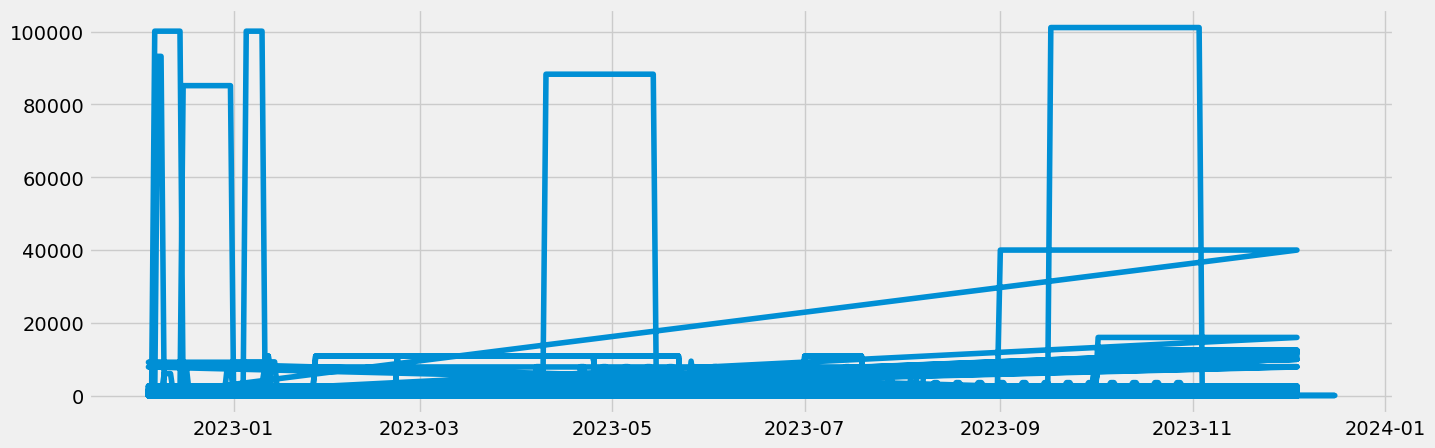

In [44]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(df_date)


I have to clean and aggregate the data before plotting it. Hence this wacky one is okay

## Cleaning and wrangling the data

In [46]:
# Check for missing values

df_date.isnull().sum() 

adjusted_price    561
dtype: int64

In [47]:
#subsetting one with adjusted price and no NULL

df_sub=df_date[df_date['adjusted_price'].isnull()==False]

In [49]:
df_sub.shape

(2484724, 1)

In [50]:
df_sub.isnull().sum() 

adjusted_price    0
dtype: int64

In [52]:
# Check for duplicates

dups = df_sub.duplicated()
dups.sum()

# No dups!

2483330

Multiple listing might have similar prices for many days, its understandable to have duplicates. Hence before this, we will convert this to day wise mean and then check duplicates

In [53]:
# resampleing suggested

daily_data = df_sub.resample('D').mean()

In [54]:
daily_data

,adjusted_price
datetime,
2022-12-05,212.426535
2022-12-06,212.567587
2022-12-07,227.650015
2022-12-08,243.560241
2022-12-09,253.837202
...,...
2023-12-12,68.000000
2023-12-13,68.000000
2023-12-14,68.000000


In [57]:
# Checking for duplicates again

dups = daily_data.duplicated()
dups.sum()

# No dups!

11

In [58]:
#removing duplicates and moving a new data frame

data_clean=daily_data.drop_duplicates()

In [59]:
data_clean.shape

(366, 1)

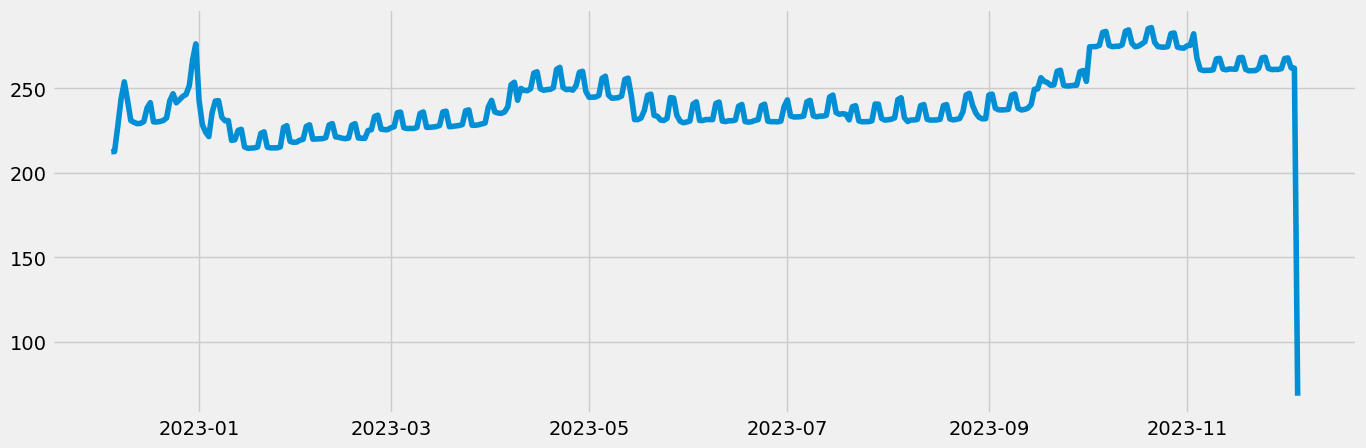

In [60]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_clean)

### 3. Time-series analysis: decomposition

In [61]:
# Decompose the time series using an additive model

decomp = sm.tsa.seasonal_decompose(data_clean, model='additive')

In [62]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

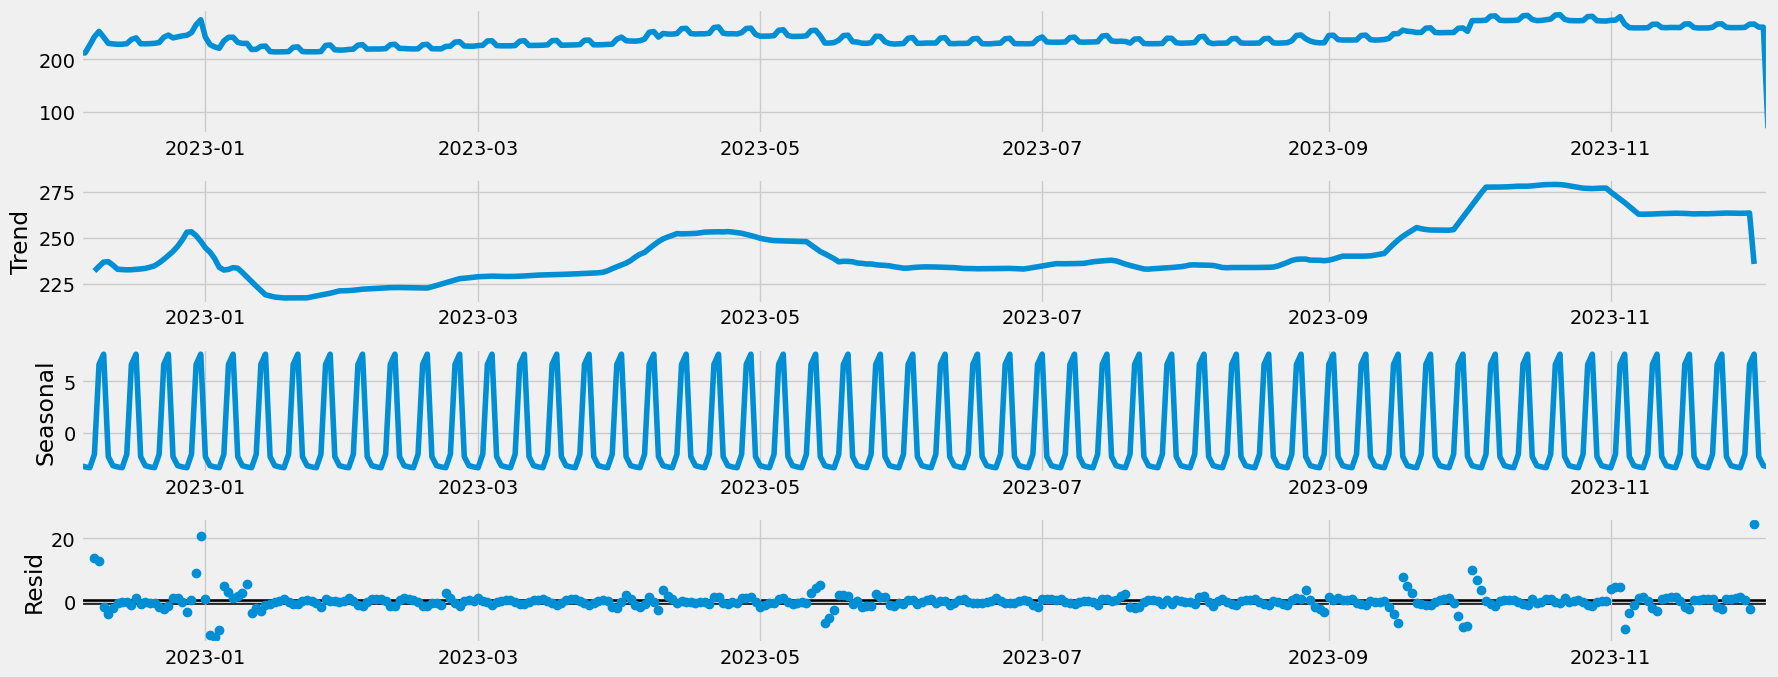

In [63]:
# Plot the separate components

decomp.plot()
plt.show()

### 4. Testing for stationarity

In [64]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. 

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_clean['adjusted_price'])

Dickey-Fuller Stationarity test:
Test Statistic                  -1.777833
p-value                          0.391521
Number of Lags Used              7.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


Test Statistic > Critical value, this means our hypothesis of present of unit root can not be rejected.

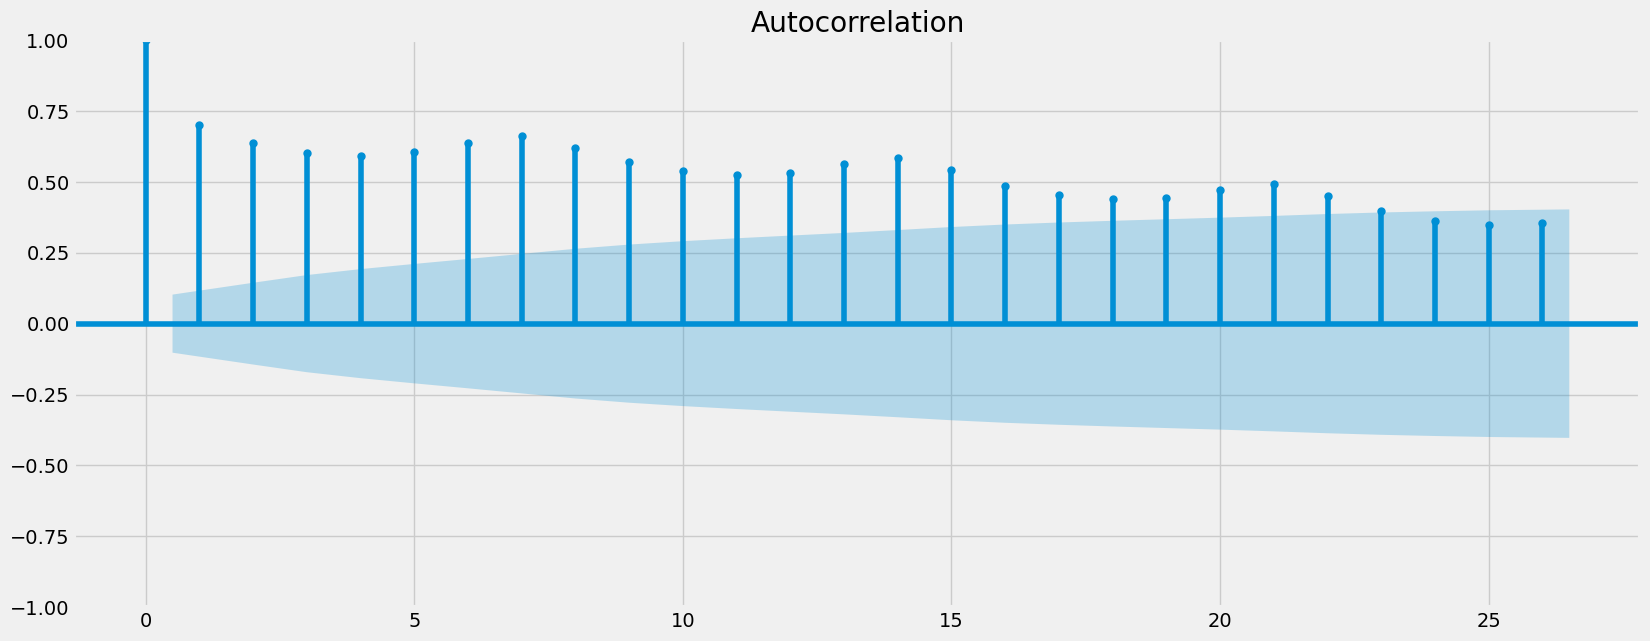

In [65]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_clean)
plt.show()

## Stationarizing the prices

In [66]:

data_diff = data_clean - data_clean.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)


In [67]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [68]:
data_diff.head()

,adjusted_price
datetime,
2022-12-06,0.141052
2022-12-07,15.082427
2022-12-08,15.910226
2022-12-09,10.276962
2022-12-10,-11.058478


In [69]:
data_diff.columns

Index(['adjusted_price'], dtype='object')

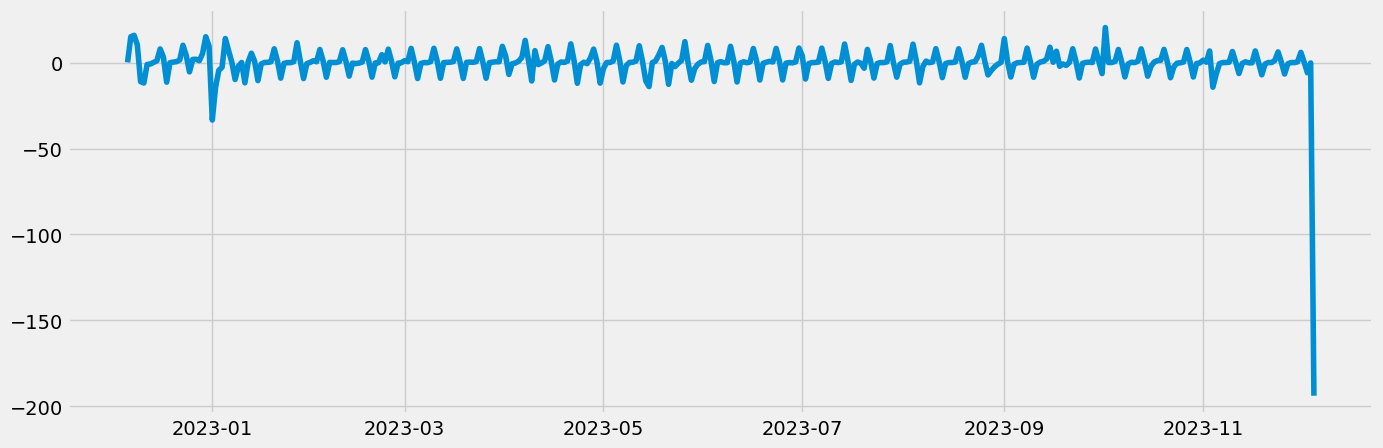

In [70]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [71]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.091065
p-value                          0.248123
Number of Lags Used              6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


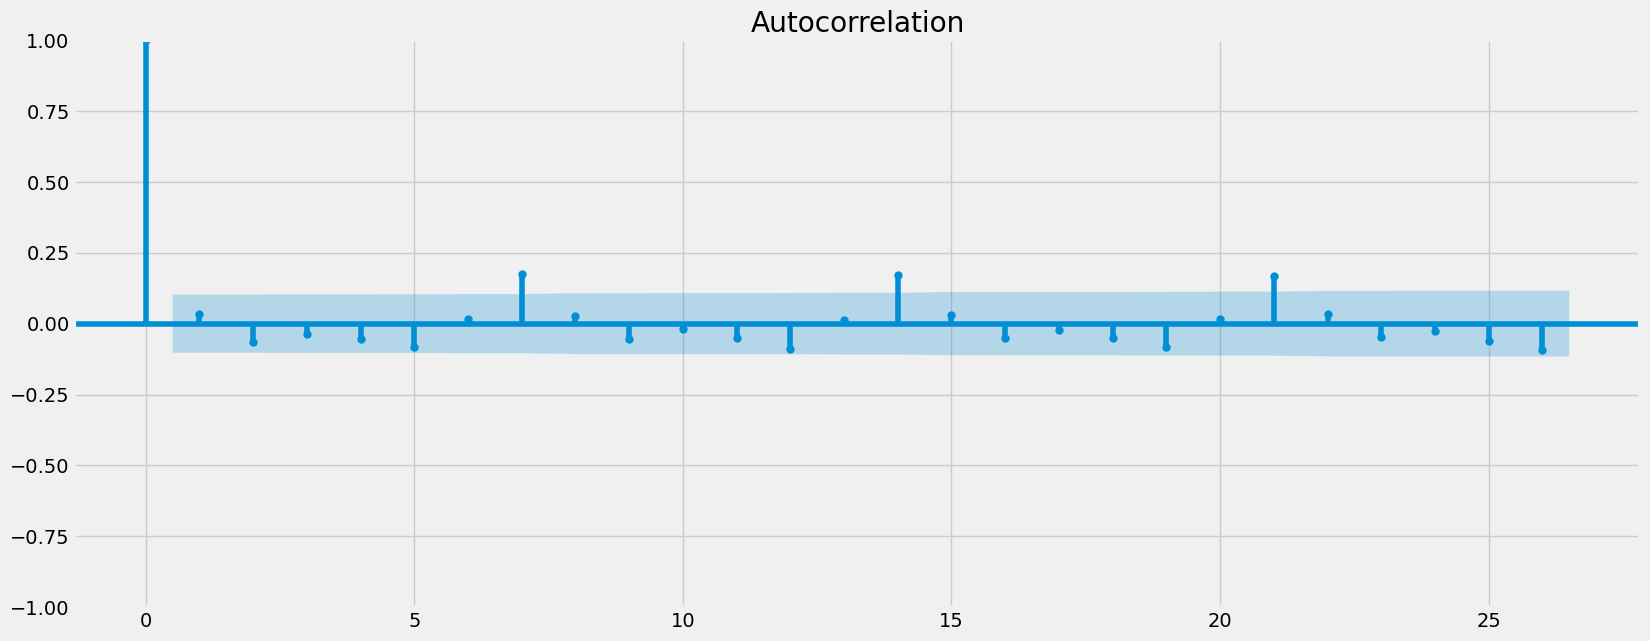

In [72]:
plot_acf(data_diff)
plt.show()

## Stationarizing again as the p-value is not less than 0.05 and test stats > critical value

In [73]:

data_diff_2 = data_diff - data_diff.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)


In [74]:
data_diff_2.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [77]:
data_diff_2.head()

,adjusted_price
datetime,
2022-12-07,14.941375
2022-12-08,0.827799
2022-12-09,-5.633265
2022-12-10,-21.335439
2022-12-11,-0.793418


In [78]:
data_diff_2.columns

Index(['adjusted_price'], dtype='object')

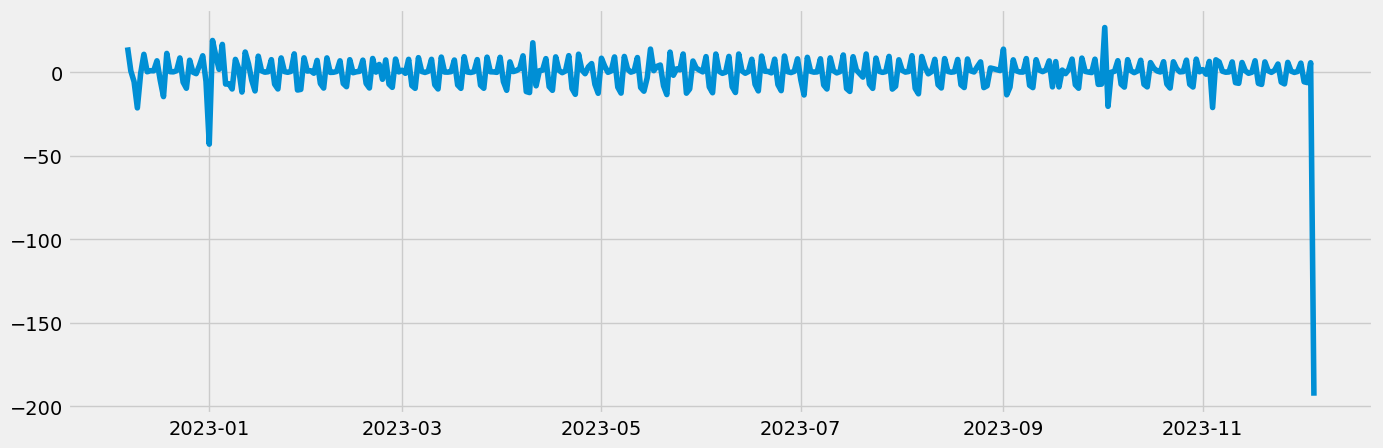

In [79]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [81]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.173166e+01
p-value                        1.337182e-21
Number of Lags Used            5.000000e+00
Number of Observations Used    3.580000e+02
Critical Value (1%)           -3.448749e+00
Critical Value (5%)           -2.869647e+00
Critical Value (10%)          -2.571089e+00
dtype: float64


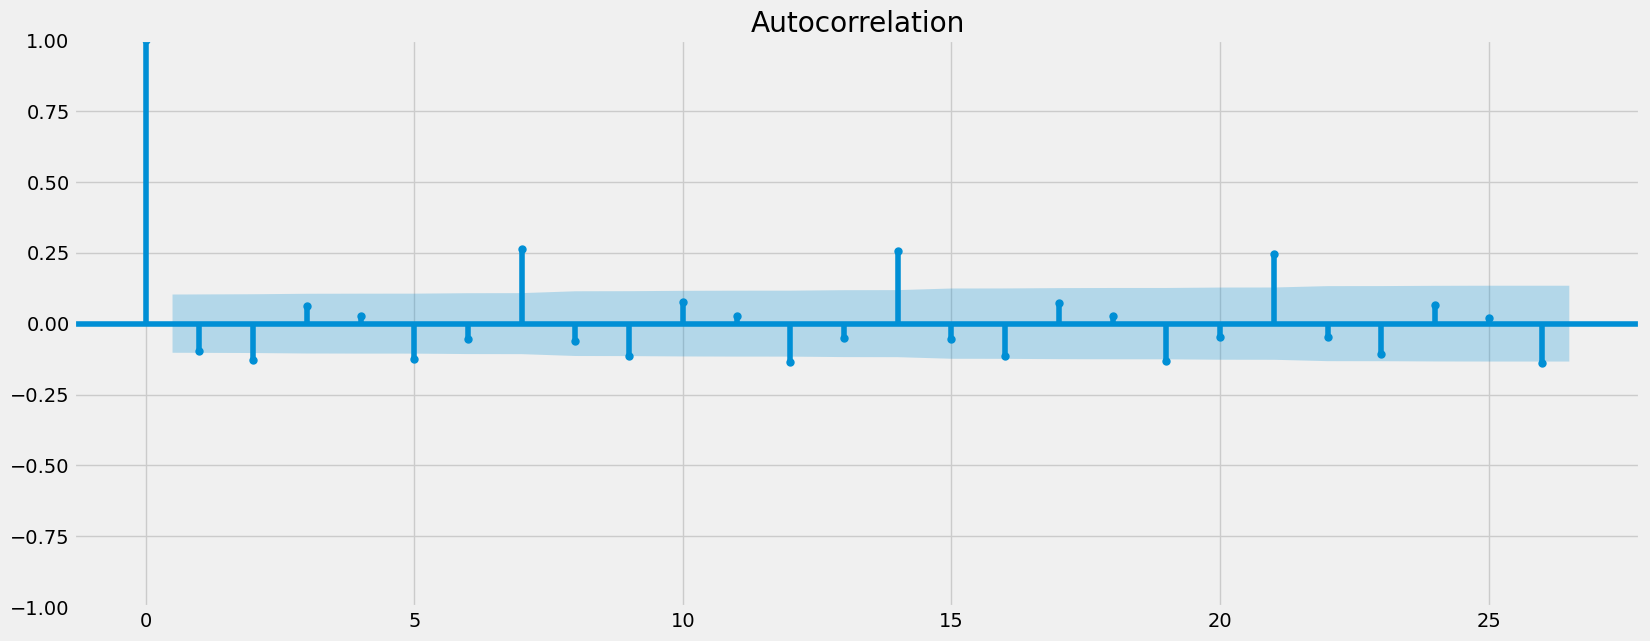

In [82]:
plot_acf(data_diff_2)
plt.show()

# Trying one more time as p-value is less than 0.05 but test stats > critical value

In [84]:

data_diff_3 = data_diff_2 - data_diff_2.shift(1) 
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [85]:
data_diff_3.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [86]:
data_diff_3.head()

,adjusted_price
datetime,
2022-12-08,-14.113576
2022-12-09,-6.461064
2022-12-10,-15.702175
2022-12-11,20.542022
2022-12-12,11.555245


In [87]:
data_diff_2.columns

Index(['adjusted_price'], dtype='object')

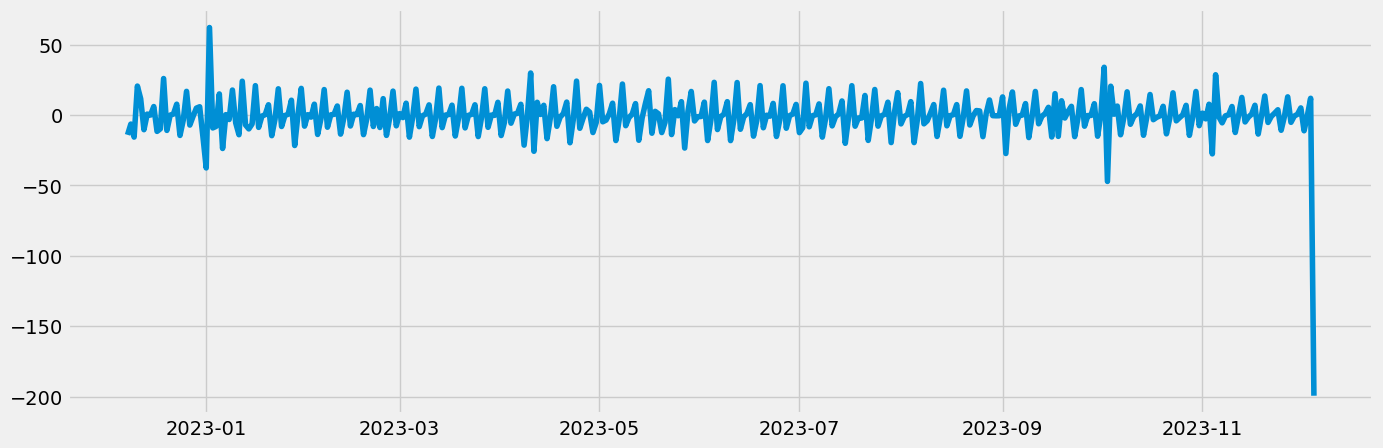

In [88]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_3)

In [89]:
dickey_fuller(data_diff_3)

Dickey-Fuller Stationarity test:
Test Statistic                -6.390984e+00
p-value                        2.106277e-08
Number of Lags Used            9.000000e+00
Number of Observations Used    3.530000e+02
Critical Value (1%)           -3.449011e+00
Critical Value (5%)           -2.869763e+00
Critical Value (10%)          -2.571151e+00
dtype: float64


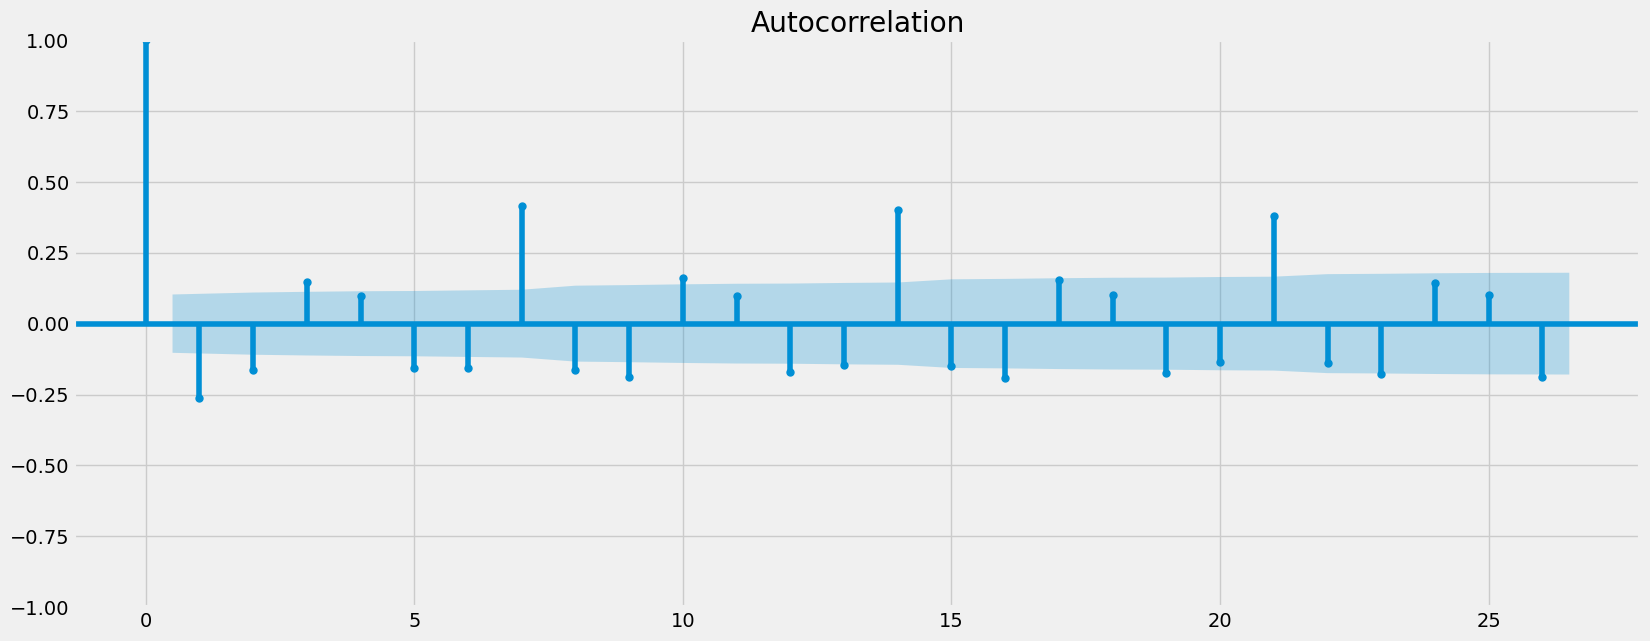

In [90]:
plot_acf(data_diff_3)
plt.show()

p-value and test stats are satisfactory. however Autocorrelation was better in the preevious data compared to this one.